In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import pulp as p
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, lpSum, LpVariable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
manuvar_costs = pd.read_excel('/content/drive/MyDrive/variable_costs.xlsx', index_col = 0)
manuvar_costs

,USA,Germany,Japan,Brazil,India
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
Germany,13,13,13,13,13
Japan,10,10,10,10,10
Brazil,8,8,8,8,8
India,5,5,5,5,5


In [ ]:
freight_costs = pd.read_excel('/content/drive/MyDrive/freight_costs.xlsx', index_col = 0)
freight_costs

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,0,12250,1100,16100,8778
Germany,13335,0,8617,20244,10073
Japan,15400,22750,0,43610,14350
Brazil,16450,22050,28000,0,29750
India,13650,15400,24500,29400,0


In [ ]:
var_cost = freight_costs/1000 + manuvar_costs
var_cost

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,12.000,24.25,13.100,28.100,20.778
Germany,26.335,13.00,21.617,33.244,23.073
Japan,25.400,32.75,10.000,53.610,24.350
Brazil,24.450,30.05,36.000,8.000,37.750
India,18.650,20.40,29.500,34.400,5.000


In [ ]:
fixed_costs = pd.read_excel('/content/drive/MyDrive/fixed_cost.xlsx', index_col = 0)
fixed_costs

,Low,High
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,6160


In [ ]:
capacity = pd.read_excel('/content/drive/MyDrive/capacity.xlsx', index_col = 0)
capacity

,Low,High
Capacity (kUnits/month),,
USA,500,1500
Germany,500,1500
Japan,500,1500
Brazil,500,1500
India,500,3000


In [ ]:
demand = pd.read_excel('/content/drive/MyDrive/demand.xlsx', names=["(Units/month)", "Demand"])
demand.set_index("(Units/month)", inplace=True)

In [ ]:
demand

,Demand
(Units/month),
USA,2800000
Germany,90000
Japan,1700000
Brazil,145000
India,160000


In [ ]:
total_costs = pd.read_excel('/content/drive/MyDrive/total_costs.xlsx', index_col = 0)
total_costs

,USA,Germany,Japan,Brazil,India
USA,6,13,20,12,17
Germany,13,6,14,14,13
Japan,20,14,3,21,9
Brazil,12,14,21,8,21
India,22,13,10,23,8


##1. Customer Demand by Market

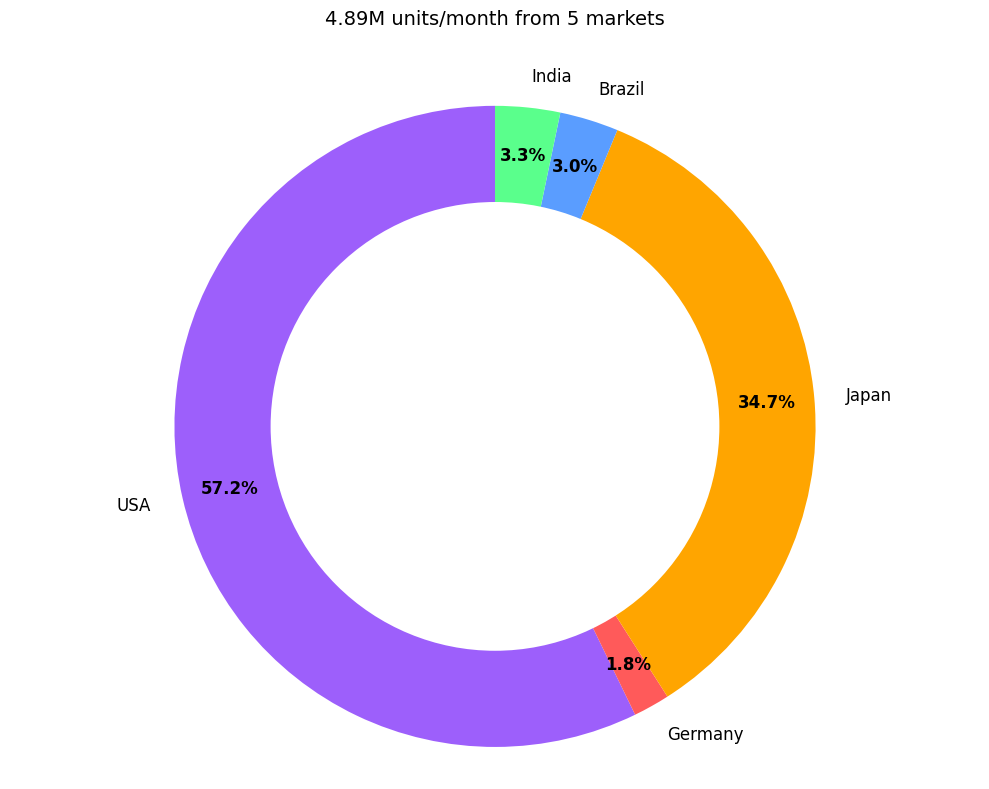


Demand Data:
Country  Demand (Units/month)  Percentage
    USA               2800000   57.201226
Germany                 90000    1.838611
  Japan               1700000   34.729316
 Brazil                145000    2.962206
  India                160000    3.268641


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Country': ['USA', 'Germany', 'Japan', 'Brazil', 'India'],
    'Demand (Units/month)': [2800000, 90000, 1700000, 145000, 160000]
}
df = pd.DataFrame(data)

total_demand = df['Demand (Units/month)'].sum()
df['Percentage'] = (df['Demand (Units/month)'] / total_demand) * 100

if total_demand >= 1e6:
    total_display = f"{total_demand/1e6:.2f}M units/month"
else:
    total_display = f"{total_demand/1e3:.0f}K units/month"

colors = [
    '#9D5FFB',
    '#FF5A5A',
    '#FFA500',
    '#5A9DFF',
    '#5AFF8C'
]

plt.figure(figsize=(10, 8))
patches, texts, autotexts = plt.pie(
    df['Demand (Units/month)'],
    labels=df['Country'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    textprops={'fontsize': 12}
)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')

plt.title(f"{total_display} from {len(df)} markets\n", fontsize=14, pad=20)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()

print("\nDemand Data:")
print(df[['Country', 'Demand (Units/month)', 'Percentage']].to_string(index=False))

##2. Transportation Cost Matrix

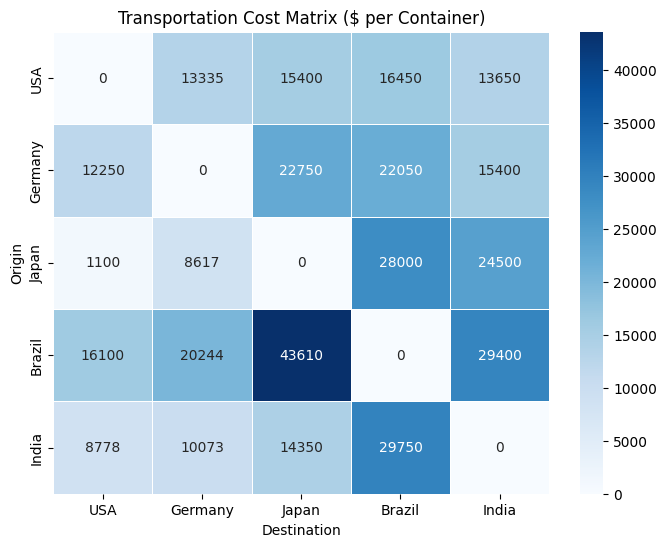

In [ ]:
!pip install seaborn matplotlib numpy

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cost_matrix = np.array([
    [0, 13335, 15400, 16450, 13650],
    [12250, 0, 22750, 22050, 15400],
    [1100, 8617, 0, 28000, 24500],
    [16100, 20244, 43610, 0, 29400],
    [8778, 10073, 14350, 29750, 0]
])

origins = ["USA", "Germany", "Japan", "Brazil", "India"]
destinations = ["USA", "Germany", "Japan", "Brazil", "India"]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cost_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=True)

ax.set_xticklabels(destinations)
ax.set_yticklabels(origins)
plt.xlabel("Destination")
plt.ylabel("Origin")
plt.title("Transportation Cost Matrix ($ per Container)")

plt.show()

##3. Fixed vs. Variable Cost Analysis

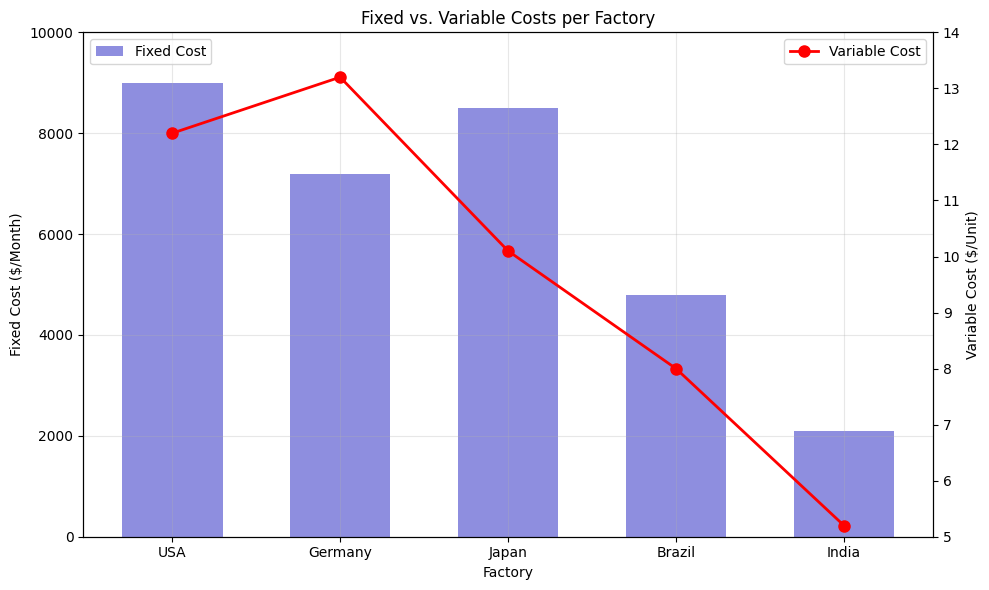

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

factories = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
fixed_costs = [9000, 7200, 8500, 4800, 2100]  # in $/Month
variable_costs = [12.2, 13.2, 10.1, 8.0, 5.2]  # in $/Unit

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

bar_width = 0.6
bar_positions = np.arange(len(factories))
bars = ax1.bar(bar_positions, fixed_costs, width=bar_width, color='#7272D8', alpha=0.8, label='Fixed Cost')

line = ax2.plot(bar_positions, variable_costs, color='red', marker='o', markersize=8,
                linewidth=2, label='Variable Cost')

ax1.set_xlabel('Factory')
ax1.set_ylabel('Fixed Cost ($/Month)')
ax2.set_ylabel('Variable Cost ($/Unit)')
plt.title('Fixed vs. Variable Costs per Factory')

plt.xticks(bar_positions, factories)

ax1.grid(True, alpha=0.3)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_ylim(0, 10000)
ax2.set_ylim(5, 14)

plt.tight_layout()

plt.show()

##4. Production Capacity per Facility

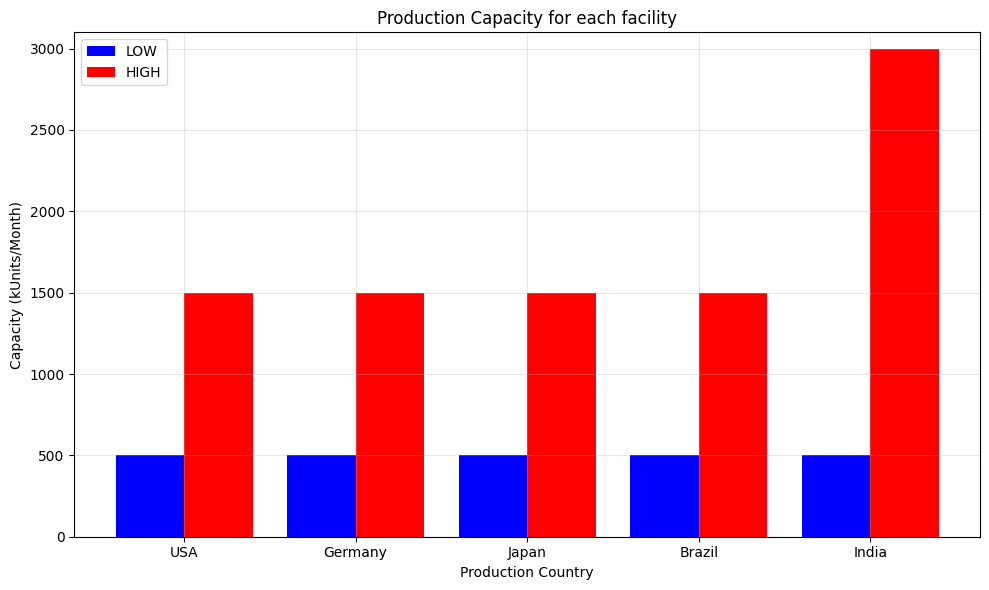

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

countries = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
low_capacity = [500, 500, 500, 500, 500]  # in kUnits/Month
high_capacity = [1500, 1500, 1500, 1500, 3000]  # in kUnits/Month

plt.figure(figsize=(10, 6))

bar_width = 0.4
index = np.arange(len(countries))

plt.bar(index - bar_width/2, low_capacity, bar_width, color='blue', label='LOW')
plt.bar(index + bar_width/2, high_capacity, bar_width, color='red', label='HIGH')

plt.xlabel('Production Country')
plt.ylabel('Capacity (kUnits/Month)')
plt.title('Production Capacity for each facility')

plt.xticks(index, countries)

plt.ylim(0, 3100)

plt.grid(True, alpha=0.3)

plt.legend()

plt.tight_layout()

plt.show()

##5. Initial Footprint Optimization Function

In [ ]:
# Define Decision Variables
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low', 'High']

In [ ]:
x = p.LpVariable.dicts("production_", [(i,j) for i in loc for j in loc], lowBound=0, upBound=None, cat=p.LpContinuous)
y = p.LpVariable.dicts("plant_", [(i,s) for s in size for i in loc], cat='Binary')

In [ ]:
model = LpProblem("Capacitated_Plant_Location_Model",LpMinimize)

In [ ]:
# Define Objective Function
model += (p.lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + p.lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

In [ ]:
demand.index = demand.index.astype(str).str.strip()
rename_map = {
    'Usa': 'USA',
    'U.s.a': 'USA',
}
demand.index = demand.index.str.title().to_series().replace(rename_map).values

In [ ]:
#Create constraints
#Production must meet or exceed demand
for j in loc:
    model += p.lpSum([x[(i, j)] for i in loc]) >= demand.loc[j,'Demand']
#Capacity limitations of factories
for i in loc:
    model += p.lpSum([x[(i, j)] for j in loc]) <= p.lpSum([capacity.loc[i,s]*y[(i,s)] * 1000 for s in size])

In [ ]:
print (model)

Capacitated_Plant_Location_Model:
MINIMIZE
4730000*plant__('Brazil',_'High') + 3230000*plant__('Brazil',_'Low') + 7270000*plant__('Germany',_'High') + 4980000*plant__('Germany',_'Low') + 6160000*plant__('India',_'High') + 2110000*plant__('India',_'Low') + 9100000*plant__('Japan',_'High') + 6230000*plant__('Japan',_'Low') + 9500000*plant__('USA',_'High') + 6500000*plant__('USA',_'Low') + 8.0*production__('Brazil',_'Brazil') + 30.05*production__('Brazil',_'Germany') + 37.75*production__('Brazil',_'India') + 36.0*production__('Brazil',_'Japan') + 24.45*production__('Brazil',_'USA') + 33.244*production__('Germany',_'Brazil') + 13.0*production__('Germany',_'Germany') + 23.073*production__('Germany',_'India') + 21.617*production__('Germany',_'Japan') + 26.335*production__('Germany',_'USA') + 34.4*production__('India',_'Brazil') + 20.4*production__('India',_'Germany') + 5.0*production__('India',_'India') + 29.5*production__('India',_'Japan') + 18.65*production__('India',_'USA') + 53.61*produc

In [ ]:
model.solve()

1

In [ ]:
for key, var in x.items():
    print(f"x[{key}] = {p.value(var)}")
for key, var in y.items():
    print(f"y[{key}] = {p.value(var)}")
print(f"Objective value: {p.value(model.objective)}")

x[('USA', 'USA')] = 1300000.0
x[('USA', 'Germany')] = 0.0
x[('USA', 'Japan')] = 200000.0
x[('USA', 'Brazil')] = 0.0
x[('USA', 'India')] = 0.0
x[('Germany', 'USA')] = 0.0
x[('Germany', 'Germany')] = 0.0
x[('Germany', 'Japan')] = 0.0
x[('Germany', 'Brazil')] = 0.0
x[('Germany', 'India')] = 0.0
x[('Japan', 'USA')] = 0.0
x[('Japan', 'Germany')] = 0.0
x[('Japan', 'Japan')] = 1500000.0
x[('Japan', 'Brazil')] = 0.0
x[('Japan', 'India')] = 0.0
x[('Brazil', 'USA')] = 0.0
x[('Brazil', 'Germany')] = 0.0
x[('Brazil', 'Japan')] = 0.0
x[('Brazil', 'Brazil')] = 145000.0
x[('Brazil', 'India')] = 0.0
x[('India', 'USA')] = 1500000.0
x[('India', 'Germany')] = 90000.0
x[('India', 'Japan')] = 0.0
x[('India', 'Brazil')] = 0.0
x[('India', 'India')] = 160000.0
y[('USA', 'Low')] = 0.0
y[('Germany', 'Low')] = 0.0
y[('Japan', 'Low')] = 0.0
y[('Brazil', 'Low')] = 1.0
y[('India', 'Low')] = 0.0
y[('USA', 'High')] = 1.0
y[('Germany', 'High')] = 0.0
y[('Japan', 'High')] = 1.0
y[('Brazil', 'High')] = 0.0
y[('India', '

In [ ]:
plant_name = [(i, s) for i in loc for s in size]
model.solve()
from pulp import LpStatus, value

print("Status: {}".format(LpStatus[model.status]))
print("Total Cost: {:,} ($/Month)".format(int(value(model.objective))))
df_bool_initial = pd.DataFrame(
    data=[y[p].varValue for p in plant_name],
    index=[f"{i}-{s}" for (i, s) in plant_name],
    columns=["Plant Opening"]
)

df_bool_initial

Status: Optimal
Total Cost: 92,981,000 ($/Month)


,Plant Opening
USA-Low,0.0
USA-High,1.0
Germany-Low,0.0
Germany-High,0.0
Japan-Low,0.0
Japan-High,1.0
Brazil-Low,1.0
Brazil-High,0.0
India-Low,0.0
India-High,1.0


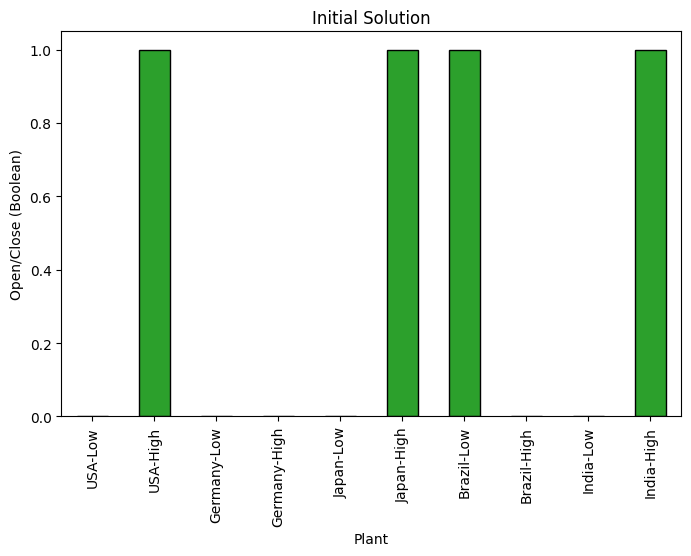

In [ ]:
capacity_plot = capacity.copy()

ax = df_bool_initial.astype(int).plot.bar(figsize=(8, 5), edgecolor='black', color = 'tab:green', y='Plant Opening', legend= False)
plt.xlabel('Plant')
plt.ylabel('Open/Close (Boolean)')
plt.title('Initial Solution')
plt.show()

##6. Net Production by Location

         Demand (Units)  Production (Units)  Net Production (Units)
USA             2800000             1500000                -1300000
Germany           90000                   0                  -90000
Japan           1700000             1500000                 -200000
Brazil           145000              145000                       0
India            160000             1750000                 1590000


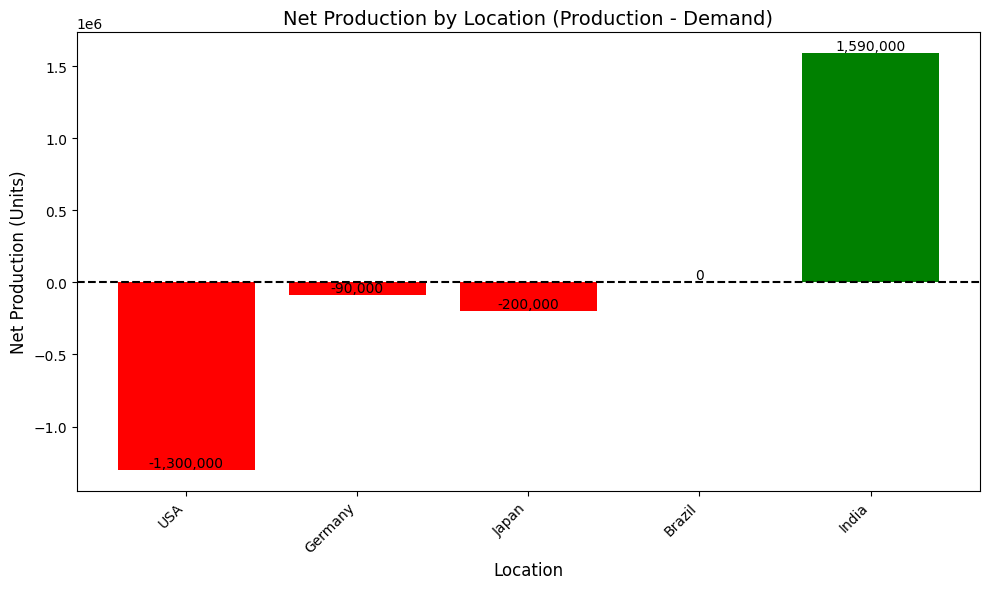

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

demand_vs_production = pd.DataFrame(index=loc, columns=['Demand (Units)', 'Production (Units)', 'Net Production (Units)'])

for location in loc:
    demand_vs_production.loc[location, 'Demand (Units)'] = demand.loc[location, 'Demand']
    demand_vs_production.loc[location, 'Production (Units)'] = sum(x[(location, dest)].varValue for dest in loc) #Total production
    demand_vs_production.loc[location, 'Net Production (Units)'] = demand_vs_production.loc[location, 'Production (Units)'] - demand_vs_production.loc[location, 'Demand (Units)']

print(demand_vs_production.astype(int).to_string(float_format='{:,.0f}'.format))  # Format values with commas and remove scientific notation

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(demand_vs_production.index, demand_vs_production['Net Production (Units)'], color=['green' if net >= 0 else 'red' for net in demand_vs_production['Net Production (Units)']])

ax.set_title('Net Production by Location (Production - Demand)', fontsize=14)
ax.set_xlabel('Location', fontsize=12)
ax.set_ylabel('Net Production (Units)', fontsize=12)
ax.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0

for bar, net in zip(bars, demand_vs_production['Net Production (Units)']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(net):,}', ha='center', va='bottom')  # Format with commas and remove scientific notation

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##7. Optimized Product Flow (Sankey Chart)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
initial_demand = demand.copy()
status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, initial_demand, 'Demand', capacity)
flow_data = [(i, j, x[(i, j)].varValue) for (i, j) in x if x[(i, j)].varValue > 0]
df_flow = pd.DataFrame([
    (f"{i} (Factory)", f"{j} (Market)", val)
    for (i, j, val) in flow_data
], columns=["Source", "Target", "Value"])
node_labels = list(pd.unique(df_flow[["Source", "Target"]].values.ravel()))
node_mapping = {name: idx for idx, name in enumerate(node_labels)}
sources = [node_mapping[src] for src in df_flow["Source"]]
targets = [node_mapping[tgt] for tgt in df_flow["Target"]]
values = df_flow["Value"].tolist()
node_colors = ["#FF5733", "#FFC300", "#33FF57", "#3388FF", "#FF33FF", "#00FFFF", "#FFD700"]
link_colors = ["rgba(255, 87, 51, 0.6)", "rgba(255, 195, 0, 0.6)", "rgba(51, 255, 87, 0.6)"] * len(sources)
link = dict(
    source=sources,
    target=targets,
    value=values,
    color=link_colors,
    hovertemplate='%{source.label} → %{target.label}<br>Units: %{value}<extra></extra>',
)
fig = go.Figure(go.Sankey(
    node=dict(
        pad=10,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors
    ),
    link=link
))
fig.update_layout(
    title_text="Optimized Production Flow (Initial Scenario)",
    font_size=12
)
fig.update_layout(title_text="Optimized Production Flow (Sankey Chart)", font_size=12)
fig.show()

##8. Cost Percentage and Value per Region

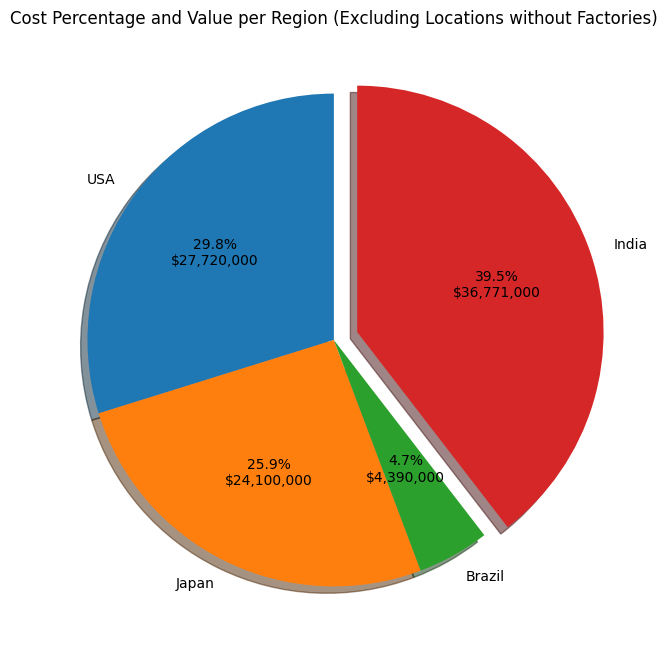

In [ ]:
prod_results = pd.DataFrame(
    data={(j): [x[(i, j)].varValue for i in loc] for j in loc},
    index=loc
)
prod_results.index.name = "Factory Location"
prod_results.columns.name = "Market Destination"
prod_results = prod_results.fillna(0).astype(int) 
region_costs = {}
for region in loc:
    if df_bool_initial.loc[[f"{region}-{size_}" for size_ in size], "Plant Opening"].any():
        fixed_cost = sum(fixed_costs.loc[region, size_] * df_bool_initial.loc[f"{region}-{size_}", "Plant Opening"] * 1000 for size_ in size)
        variable_cost = sum(var_cost.loc[region, dest] * prod_results.loc[region, dest] for dest in loc)
        region_costs[region] = fixed_cost + variable_cost

total_cost = sum(region_costs.values())
region_percentages = {region: (cost / total_cost) * 100 for region, cost in region_costs.items()}

plt.figure(figsize=(8, 8))
explode = [0.1 if region == max(region_percentages, key=region_percentages.get) else 0 for region in region_percentages]
wedges, texts, autotexts = plt.pie(region_percentages.values(), labels=region_percentages.keys(),
                                   autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)

for i, autotext in enumerate(autotexts):
    region = texts[i].get_text()
    cost = region_costs[region]
    autotext.set_text(f'{autotext.get_text()}\n${cost:,.0f}')

plt.title('Cost Percentage and Value per Region (Excluding Locations without Factories)')
plt.show()

##9. Factory Capacity Utilization

In [ ]:
utilization_data = []

for i in loc:
    total_output = sum(x[(i, j)].varValue for j in loc if x[(i, j)].varValue is not None)
    active_size = None
    for s in size:
        if y[(i, s)].varValue == 1:
            active_size = s
            break

    if active_size is not None:
        max_capacity = capacity.loc[i, active_size] * 1000
        utilization = total_output / max_capacity
    else:
        max_capacity = 0
        utilization = 0

    utilization_data.append({
        "Factory": i,
        "Capacity Type": active_size if active_size else "None",
        "Output": total_output,
        "Capacity": max_capacity,
        "Utilization (%)": round(utilization * 100, 2) if max_capacity > 0 else 0
    })

In [ ]:
df_util = pd.DataFrame(utilization_data)
display(df_util)

,Factory,Capacity Type,Output,Capacity,Utilization (%)
0,USA,High,1500000.0,1500000,100.00
1,Germany,None,0.0,0,0.00
2,Japan,High,1500000.0,1500000,100.00
3,Brazil,Low,145000.0,500000,29.00
4,India,High,1750000.0,3000000,58.33


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

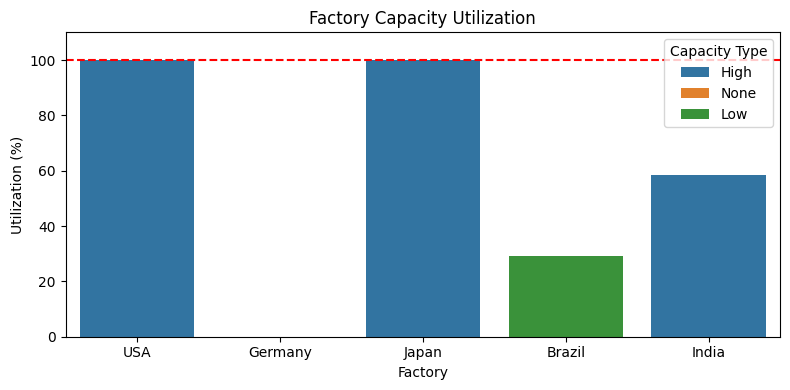

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(data=df_util, x="Factory", y="Utilization (%)", hue="Capacity Type")
plt.title("Factory Capacity Utilization")
plt.ylim(0, 110)
plt.axhline(100, color='red', linestyle='--')
plt.tight_layout()
plt.savefig('factory_capacity_utilization.png', dpi=300)
from google.colab import files
files.download('factory_capacity_utilization.png')
plt.show()

##10. Cost Breakdown by Factory/Region

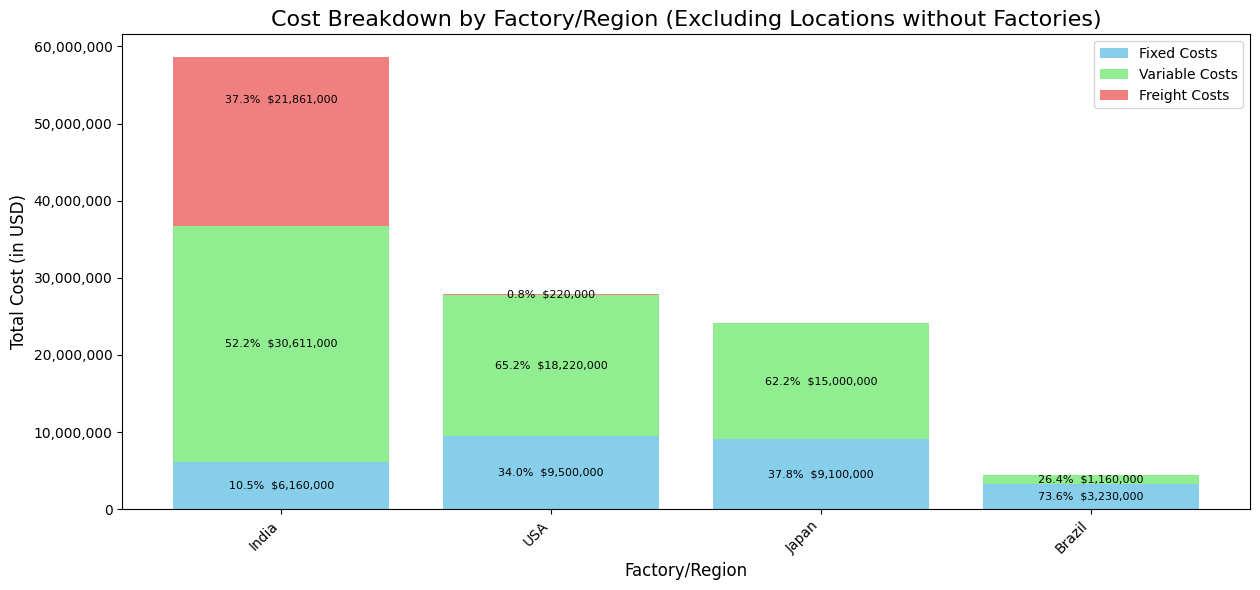

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

total_production = prod_results.sum(axis=1)

factories_with_production = total_production[total_production > 0].index

fixed_costs_total = []
variable_costs_total = []
freight_costs_total = []

for region in factories_with_production:
    fixed_cost = sum(fixed_costs.loc[region, size_] * df_bool_initial.loc[f"{region}-{size_}", "Plant Opening"] * 1000 for size_ in ['Low', 'High'])
    fixed_costs_total.append(fixed_cost)

    variable_cost = sum(var_cost.loc[region, dest] * prod_results.loc[region, dest] for dest in loc)
    variable_costs_total.append(variable_cost)

    freight_cost = sum((freight_costs.loc[region, dest] / 1000) * prod_results.loc[region, dest] for dest in loc)
    freight_costs_total.append(freight_cost)

cost_data = pd.DataFrame({'Fixed Costs': fixed_costs_total,
                          'Variable Costs': variable_costs_total,
                          'Freight Costs': freight_costs_total},
                         index=factories_with_production)

cost_data['Total Cost'] = cost_data.sum(axis=1)

cost_data = cost_data.sort_values(by=['Total Cost'], ascending=False)

sorted_factories = cost_data.index

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(sorted_factories, cost_data['Fixed Costs'], label='Fixed Costs', color='skyblue')
ax.bar(sorted_factories, cost_data['Variable Costs'], bottom=cost_data['Fixed Costs'], label='Variable Costs', color='lightgreen')
ax.bar(sorted_factories, cost_data['Freight Costs'], bottom=cost_data['Fixed Costs'] + cost_data['Variable Costs'], label='Freight Costs', color='lightcoral')
ax.set_title('Cost Breakdown by Factory/Region (Excluding Locations without Factories)', fontsize=16)
ax.set_xlabel('Factory/Region', fontsize=12)
ax.set_ylabel('Total Cost (in USD)', fontsize=12)  # Change y-axis label to USD
ax.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for i, region in enumerate(sorted_factories):  # Use sorted_factories here
    total_cost = cost_data.loc[region, 'Total Cost']  # Get total cost from DataFrame

    if cost_data.loc[region, 'Fixed Costs'] > 0:
        ax.text(i, cost_data.loc[region, 'Fixed Costs'] / 2, f'{cost_data.loc[region, "Fixed Costs"]/total_cost:.1%}  ${cost_data.loc[region, "Fixed Costs"]:,.0f}', ha='center', va='center', color='black', fontsize=8)

    if cost_data.loc[region, 'Variable Costs'] > 0:
        ax.text(i, cost_data.loc[region, 'Fixed Costs'] + cost_data.loc[region, 'Variable Costs'] / 2, f'{cost_data.loc[region, "Variable Costs"]/total_cost:.1%}  ${cost_data.loc[region, "Variable Costs"]:,.0f}', ha='center', va='center', color='black', fontsize=8)

    if cost_data.loc[region, 'Freight Costs'] > 0:
        ax.text(i, cost_data.loc[region, 'Fixed Costs'] + cost_data.loc[region, 'Variable Costs'] + cost_data.loc[region, 'Freight Costs'] * 0.75, f'{cost_data.loc[region, "Freight Costs"]/total_cost:.1%}  ${cost_data.loc[region, "Freight Costs"]:,.0f}', ha='center', va='center', color='black', fontsize=8)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))  # Format y-axis in USD

plt.show()

##11. Varying Penalty Rates

In [ ]:
import numpy as np
import pandas as pd
import pulp as p
from pulp import LpProblem, LpMinimize, lpSum, LpVariable
import matplotlib.pyplot as plt
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
penalty_rates = np.arange(0.6, 2.1, 0.1)
results_table = pd.DataFrame(index=loc, columns=[f'{rate:.1f}' for rate in penalty_rates])

for penalty_rate in penalty_rates:
    size = ['Low', 'High']
    plant_name = [(i, s) for s in size for i in loc]
    prod_name = [(i, j) for i in loc for j in loc]
    model = LpProblem("Capacitated Plant Location Model", LpMinimize)
    x = LpVariable.dicts("production_", prod_name, lowBound=0, cat='Continuous')
    y = LpVariable.dicts("plant_", plant_name, cat='Binary')

    unmet = LpVariable.dicts("unmet", loc, lowBound=0, cat='Continuous')

    avg_cost = var_cost.loc[loc, loc].to_numpy().mean()
    penalty = penalty_rate * avg_cost

    model += (
        lpSum([fixed_costs.loc[i, s] * y[(i, s)] * 1000 for s in size for i in loc])
        + lpSum([var_cost.loc[i, j] * x[(i, j)] for i in loc for j in loc])
        + penalty * lpSum([unmet[j] for j in loc])
    ), "Total_Cost"

    for j in loc:
        model += (
            lpSum([x[(i, j)] for i in loc]) + unmet[j] == demand.loc[j, 'Demand']
        ), f"Demand_{j}" # New

    for i in loc:
        model += (
            lpSum([x[(i, j)] for j in loc])
            <= lpSum([capacity.loc[i, s] * y[(i, s)] * 1000 for s in size])
        ), f"Capacity_{i}"
    model.solve()


    for region in loc:
        plant_open = 0
        for size_ in size:
            if y[(region, size_)].varValue == 1:
                plant_open = 1
                break
        results_table.loc[region, f'{penalty_rate:.1f}'] = plant_open
results_table.columns.name = "Penalty Rate (comparing to Average Variable Cost)"
print(results_table)

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '

Penalty Rate (comparing to Average Variable Cost) 0.6 0.7 0.8 0.9 1.0 1.1 1.2  \
USA                                                 0   0   1   1   1   1   1   
Germany                                             0   0   0   0   0   0   0   
Japan                                               0   1   1   1   1   1   1   
Brazil                                              0   0   0   0   0   0   0   
India                                               0   0   1   1   1   1   1   

Penalty Rate (comparing to Average Variable Cost) 1.3 1.4 1.5 1.6 1.7 1.8 1.9  \
USA                                                 1   1   1   1   1   1   1   
Germany                                             0   0   0   0   0   0   0   
Japan                                               1   1   1   1   1   1   1   
Brazil                                              1   1   1   1   1   1   1   
India                                               1   1   1   1   1   1   1   

Penalty Rate (comparing to

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [ ]:
avg_cost = var_cost.loc[loc, loc].to_numpy().mean()
avg_cost*1.2

np.float64(29.078736)

##12. Multiple Demand Scenarios - Demand Variability Modeling Using Normal Distribution

In [ ]:
import pulp as p

def optimization_model(fixed_costs, var_cost, demand, demand_col, cap):
    """
    Run the supply chain optimization model with given input data.
    """
    loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
    size = ['Low', 'High']
    plant_name = [(i, s) for s in size for i in loc]
    prod_name = [(i, j) for i in loc for j in loc]

    model = p.LpProblem("Capacitated_Plant_Location_Model", p.LpMinimize)

    x = p.LpVariable.dicts("production_", prod_name, lowBound=0, upBound=None, cat='Continuous')
    y = p.LpVariable.dicts("plant_", plant_name, cat='Binary')

    model += (
        p.lpSum([fixed_costs.loc[i, s] * y[(i, s)] * 1000 for i in loc for s in size]) +
        p.lpSum([var_cost.loc[i, j] * x[(i, j)] for i in loc for j in loc])
    )

    for j in loc:
        model += p.lpSum([x[(i, j)] for i in loc]) == demand.loc[j, demand_col]  # satisfy demand

    for i in loc:
        model += p.lpSum([x[(i, j)] for j in loc]) <= p.lpSum([cap.loc[i, s] * y[(i, s)] * 1000 for s in size])  # capacity

    model.solve()

    status_out = p.LpStatus[model.status]
    objective_out = p.value(model.objective)
    plant_bool = [y[(i, s)].varValue for (i, s) in plant_name]
    fix = sum([fixed_costs.loc[i, s] * y[(i, s)].varValue * 1000 for i in loc for s in size])
    var = sum([var_cost.loc[i, j] * x[(i, j)].varValue for i in loc for j in loc])

    return status_out, objective_out, y, x, fix, var

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import truncnorm

N = 50
CV = 0.5


df_demand = pd.DataFrame({'scenario': np.arange(1, N + 1)})
data = demand.reset_index()


markets = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
for _, row in data.iterrows():
    market = row['(Units/month)']
    mean = row['Demand']
    sigma = CV * mean

    a, b = 0, np.inf
    lower = (a - mean) / sigma
    upper = (b - mean) / sigma

    truncated_samples = truncnorm.rvs(lower, upper, loc=mean, scale=sigma, size=N)
    df_demand[market] = np.round(truncated_samples)


init_row = {'scenario': 0, **dict(zip(data['(Units/month)'], data['Demand']))}
df_init = pd.DataFrame([init_row])
df_demand = pd.concat([df_init, df_demand], ignore_index=True)


path = '/content/drive/MyDrive/demand_scenarios'
os.makedirs(path, exist_ok=True)
df_demand.to_excel(f'{path}/df_demand_truncnorm_{int(CV*100)}PC.xlsx', index=False)

df_demand.head()

,scenario,USA,Germany,Japan,Brazil,India
0,0,2800000.0,90000.0,1700000.0,145000.0,160000.0
1,1,1533582.0,145460.0,775877.0,95111.0,149304.0
2,2,2357737.0,35206.0,1576782.0,90784.0,74943.0
3,3,4936827.0,109469.0,850393.0,203817.0,89234.0
4,4,965583.0,189994.0,2686204.0,281464.0,281160.0


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


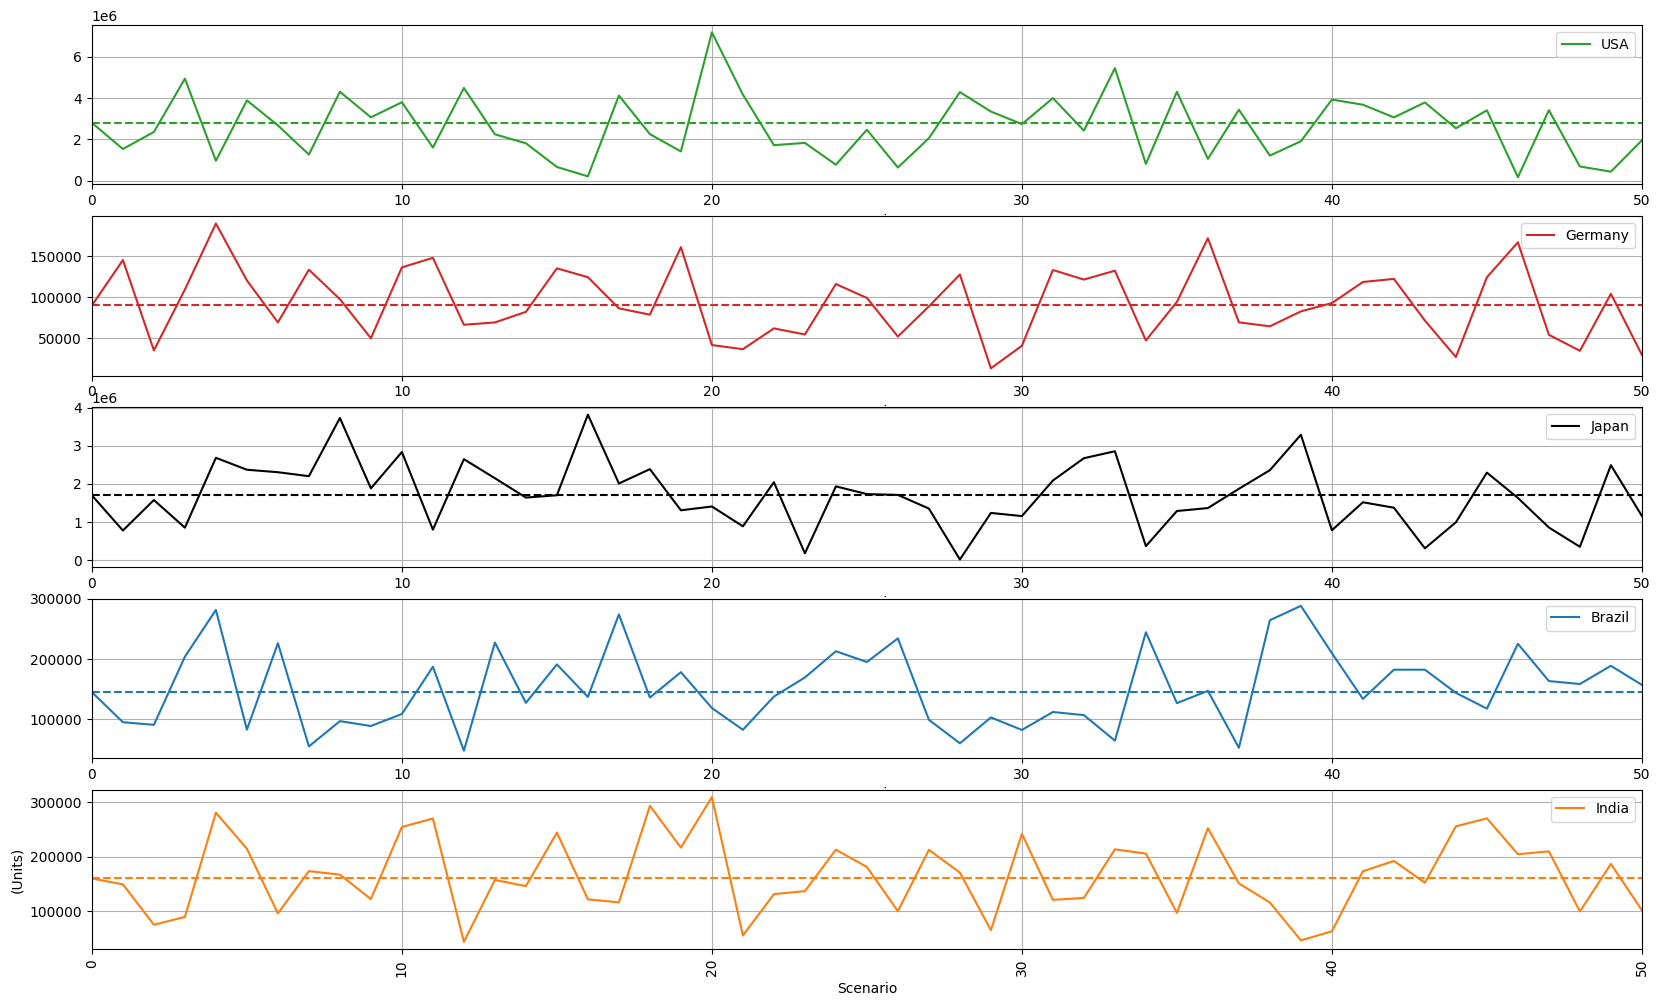

In [ ]:
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(20, 12), xlim=[0,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].values[0], color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')
plt.xticks(rotation=90)
from google.colab import drive
drive.mount('/content/drive')
plt.savefig("demand_variation_plot.png", bbox_inches='tight')
drive_path = "/content/drive/MyDrive/demand_scenarios/demand_variation_plot.png"
plt.savefig(drive_path, bbox_inches='tight')

plt.show()

In [ ]:
from pulp import LpStatus, value
import pandas as pd

# --- INIT storage ---
list_scenario, list_status, list_results = [], [], []
list_totald, list_fixcost, list_varcost = [], [], []

# --- RUN Initial Scenario ---
status_out, objective_out, y, x, fix, var = optimization_model(
    fixed_costs, var_cost, demand, 'Demand', capacity
)

# --- SAVE ---
list_scenario.append('INITIAL')
list_status.append(status_out)
list_results.append(objective_out)
list_totald.append(demand['Demand'].sum())
list_fixcost.append(fix)
list_varcost.append(var)

# --- FACTORY OPENING MATRIX ---
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low', 'High']
plant_name = [(i, s) for s in size for i in loc]

df_bool = pd.DataFrame(
    data=[y[p].varValue for p in plant_name],
    index=[f"{i}-{s}" for (i, s) in plant_name],
    columns=['INITIAL']
)

# --- DISPLAY ---
df_bool

,INITIAL
USA-Low,0.0
Germany-Low,0.0
Japan-Low,0.0
Brazil-Low,1.0
India-Low,0.0
USA-High,1.0
Germany-High,0.0
Japan-High,1.0
Brazil-High,0.0
India-High,1.0


In [ ]:
# Simulate all scenarios
demand_var = df_demand.drop(['scenario'], axis = 1).T

# Loop
for i in range(1, 50): # 0 is the initial scenario
    # Calculations
    status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand_var, i, capacity)

    # Append results
    list_status.append(status_out)
    list_results.append(objective_out)
    df_bool[i] = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    list_fixcost.append(fix)
    list_varcost.append(var)
    total_demand = demand_var[i].sum()
    list_totald.append(total_demand)
    list_scenario.append(i)
# Final Results
# Boolean
df_bool = df_bool.astype(int)
path = '/content/drive/MyDrive/demand_scenarios'
os.makedirs(path, exist_ok=True)
df_demand.to_excel(f'{path}/df_all_scenarios_{int(CV*100)}PC.xlsx', index=False)
# Other Results
df_bool

,INITIAL,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
USA-Low,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Germany-Low,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Japan-Low,0,0,0,0,1,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Brazil-Low,1,0,0,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,1,0,1
India-Low,0,1,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1
USA-High,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
Germany-High,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Japan-High,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,0,0,1
Brazil-High,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
India-High,1,0,1,1,0,1,1,0,1,1,...,1,1,1,1,1,1,0,1,0,0


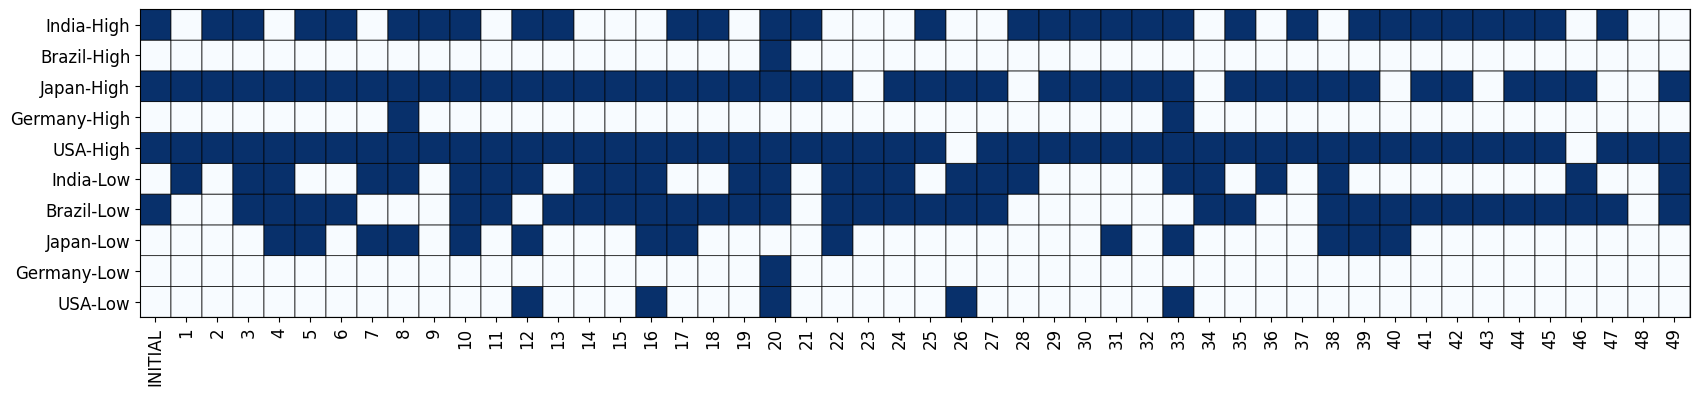

In [ ]:
# Plot the Grid
plt.figure(figsize = (20,4))
plt.pcolor( df_bool, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.savefig('/content/drive/MyDrive/demand_scenarios/factory_selection_grid.png', dpi=300)
plt.show()

##13. Sensitivity Analysis

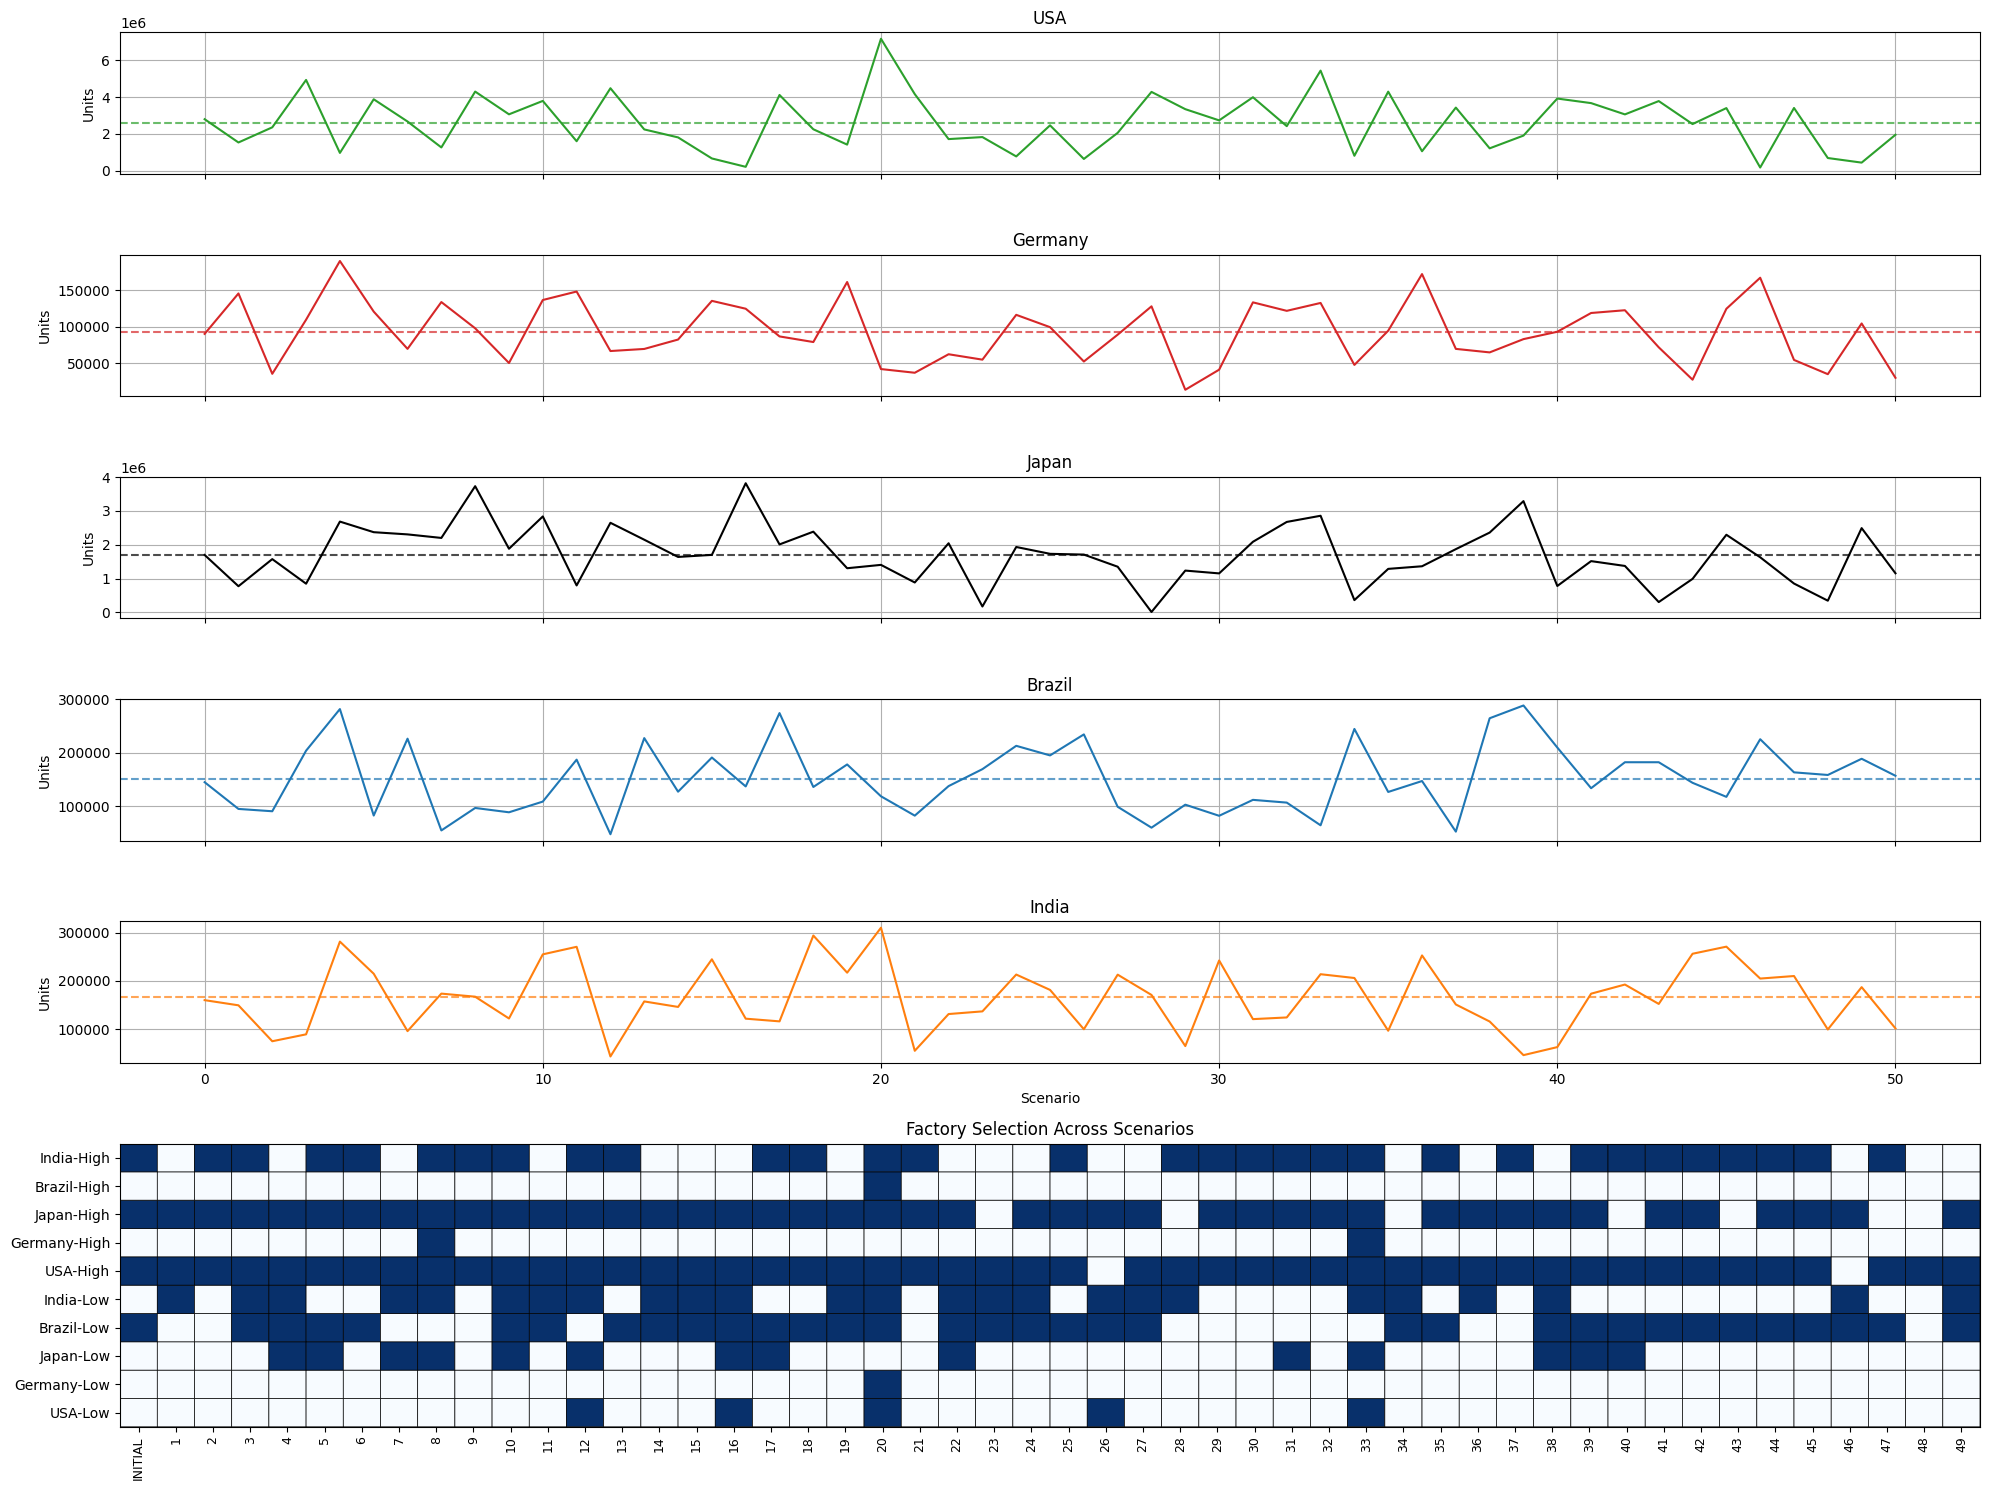

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(6, 1, height_ratios=[1, 1, 1, 1, 1, 2])
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
market_names = markets

for i, market in enumerate(market_names):
    ax = fig.add_subplot(gs[i])
    ax.plot(df_demand['scenario'], df_demand[market], color=colors[i], label=market)
    ax.axhline(df_demand[market].mean(), color=colors[i], linestyle='--', alpha=0.7)
    ax.set_ylabel('Units')
    ax.set_title(market)
    ax.grid(True)
    if i == len(market_names) - 1:
        ax.set_xlabel('Scenario')
    else:
        ax.set_xticklabels([])

ax_grid = fig.add_subplot(gs[5])
ax_grid.pcolor(df_bool, cmap='Blues', edgecolors='k', linewidths=0.5)
ax_grid.set_xticks([i + 0.5 for i in range(df_bool.shape[1])])
ax_grid.set_xticklabels(df_bool.columns, rotation=90, fontsize=9)
ax_grid.set_yticks([i + 0.5 for i in range(df_bool.shape[0])])
ax_grid.set_yticklabels(df_bool.index, fontsize=10)
ax_grid.set_title("Factory Selection Across Scenarios")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/demand_scenarios/separated_demand_and_selection.png', dpi=300, bbox_inches='tight')
plt.show()

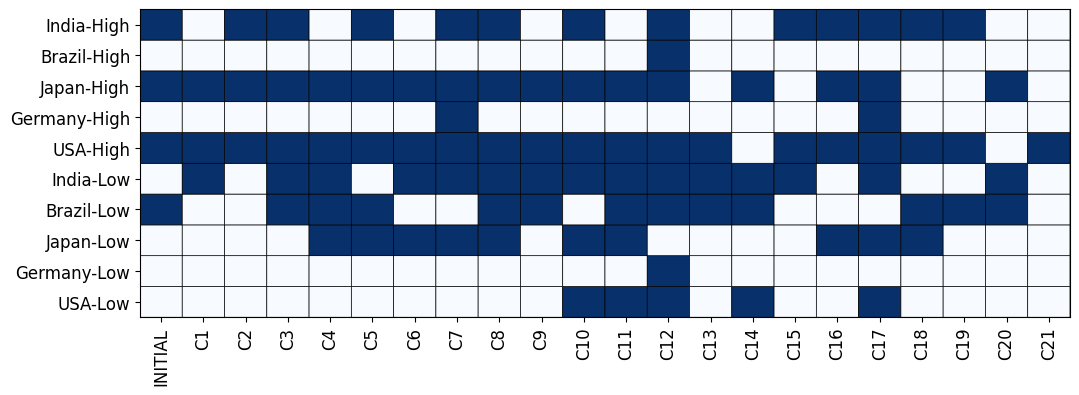

In [ ]:
# Unique combinations
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]
# Plot the Grid
plt.figure(figsize = (12,4))
plt.pcolor( df_unique, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.show()

##14. Quantify the Frequency of Each Configuration

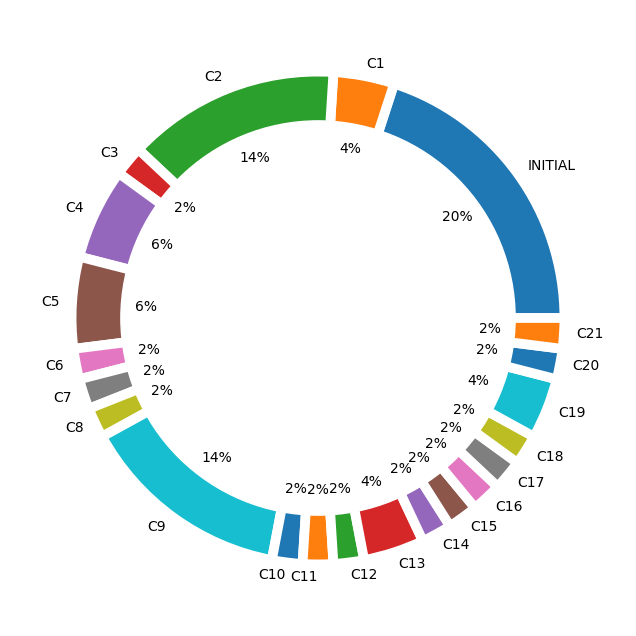

In [ ]:
# Number of columns
COL_NAME, COL_NUMBER = [], []
for col1 in df_unique.columns:
    count = 0
    COL_NAME.append(col1)
    for col2 in df_bool.columns:
        if (df_bool[col2]!=df_unique[col1]).sum()==0:
            count += 1
    COL_NUMBER.append(count)
df_comb = pd.DataFrame({'column':COL_NAME, 'count':COL_NUMBER}).set_index('column')

my_circle = plt.Circle( (0,0), 0.8, color='white')
df_comb.plot.pie(figsize=(8, 8), x='column', y='count', legend= False, pctdistance=0.7,
                                          autopct='%1.0f%%', labeldistance=1.05,
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
# plt.title('{:.2f} M€ Budget Applications in 9 Vertical Markets'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

##15. Calculating Utilization Of INITIAL, C2, And C9 Footprints

In [ ]:
from pulp import *

def optimization_model(fixed_costs, var_cost, demand_row, capacity, bool_df, scenario_name):
    # --- Define sets ---
    loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
    size = ['Low', 'High']
    plant_name = [(i, s) for s in size for i in loc]
    prod_name = [(i, j) for i in loc for j in loc]

    # --- Create model ---
    model = LpProblem("Capacitated_Plant_Location_Model", LpMinimize)

    # --- Decision variables ---
    x = LpVariable.dicts("production_", prod_name, lowBound=0, cat='Continuous')
    y = LpVariable.dicts("plant_", plant_name, cat='Binary')

    # --- Objective function ---
    model += (
        lpSum(fixed_costs.loc[i, s] * y[(i, s)] * 1000 for i in loc for s in size) +
        lpSum(var_cost.loc[i, j] * x[(i, j)] for i in loc for j in loc)
    )

    # --- Constraints ---
    # Demand satisfaction
    for j in loc:
        model += lpSum(x[(i, j)] for i in loc) >= demand_row[j]

    # Capacity limit
    for i in loc:
        model += lpSum(x[(i, j)] for j in loc) <= lpSum(capacity.loc[i, s] * y[(i, s)] * 1000 for s in size)

    # Enforce selection from bool_df (e.g., df_unique)
    for i in loc:
      for s in size:
        key = f"{i}-{s}"
        if bool_df.loc[key, scenario_name] == 0:
            model += y[(i, s)] == 0
        else:
            model += y[(i, s)] == 1

    # --- Solve model ---
    model.solve()

    # --- Extract results ---
    status_out = LpStatus[model.status]
    objective_out = value(model.objective)

    fix = sum(fixed_costs.loc[i, s] * 1000 * y[(i, s)].varValue for i in loc for s in size)
    var = sum(var_cost.loc[i, j] * x[(i, j)].varValue for i in loc for j in loc)

    return status_out, objective_out, y, x, fix, var

In [ ]:
row_initial = df_demand.loc[df_demand['scenario'] == 0].iloc[0]
row_c2 = df_demand.loc[df_demand['scenario'] == 2].iloc[0]
row_c9 = df_demand.loc[df_demand['scenario'] == 9].iloc[0]

status_0, obj_0, y_0, x_0, fix_0, var_0 = optimization_model(fixed_costs, var_cost, row_initial, capacity, df_unique, 'INITIAL')
status_2, obj_2, y_2, x_2, fix_2, var_2 = optimization_model(fixed_costs, var_cost, row_c2, capacity, df_unique, 'C2')
status_9, obj_9, y_9, x_9, fix_9, var_9 = optimization_model(fixed_costs, var_cost, row_c9, capacity, df_unique, 'C9')

In [ ]:
def calculate_utilization_manual(x_scenario, y_scenario, capacity_df):
    loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
    size = ['Low', 'High']

    utilization_data = []

    for i in loc:
        # Tổng sản lượng từ nhà máy i đến các thị trường
        total_output = sum(x_scenario[(i, j)].varValue for j in loc if x_scenario[(i, j)].varValue is not None)

        # Xác định nhà máy (Low hoặc High) được mở
        active_size = None
        for s in size:
            if y_scenario[(i, s)].varValue == 1:
                active_size = s
                break

        if active_size is not None:
            max_capacity = capacity_df.loc[i, active_size] * 1000
            utilization = round(total_output / max_capacity * 100, 2)
        else:
            max_capacity = 0
            utilization = 0

        utilization_data.append({
            'Factory': i,
            'Capacity Type': active_size if active_size else 'None',
            'Output': total_output,
            'Capacity': max_capacity,
            'Utilization (%)': utilization
        })

    return pd.DataFrame(utilization_data)

In [ ]:
df_util_0 = calculate_utilization_manual(x_0, y_0, capacity)
df_util_2 = calculate_utilization_manual(x_2, y_2, capacity)
df_util_9 = calculate_utilization_manual(x_9, y_9, capacity)


df_util_0['Scenario'] = 'INITIAL'
df_util_2['Scenario'] = 'C2'
df_util_9['Scenario'] = 'C9'


df_util_all = pd.concat([df_util_0, df_util_2, df_util_9], ignore_index=True)


full_index = pd.MultiIndex.from_product([['USA', 'Germany', 'Japan', 'Brazil', 'India'], ['Low', 'High']], names=['Factory', 'Capacity Type'])


df_util_pivot = df_util_all.pivot_table(
    index=['Factory', 'Capacity Type'],
    columns='Scenario',
    values='Utilization (%)'
).reindex(full_index).fillna(0)

display(df_util_pivot)

Scenario                   C2     C9  INITIAL
Factory Capacity Type                        
USA     Low              0.00    0.0     0.00
        High           100.00  100.0   100.00
Germany Low              0.00    0.0     0.00
        High             0.00    0.0     0.00
Japan   Low              0.00    0.0     0.00
        High           100.00  100.0   100.00
Brazil  Low              0.00  341.9    29.00
        High             0.00    0.0     0.00
India   Low              0.00  100.0     0.00
        High            37.85    0.0    58.33

##16. Calculating Cost Efficiency for INITIAL and C2 Footprints

In [ ]:
# Evaluate cost of INITIAL footprint across 50 scenarios
results_initial = []

for i in range(50):
    demand_row = df_demand.iloc[i]
    status, obj, y, x, fix, var = optimization_model(
        fixed_costs, var_cost, demand_row, capacity,
        df_unique, 'INITIAL'
    )

    results_initial.append({
        'Scenario': i,
        'Status': status,
        'Total Cost': obj,
        'Fixed Cost': fix,
        'Variable Cost': var,
    })
df_results_initial = pd.DataFrame(results_initial)
display(df_results_initial)

,Scenario,Status,Total Cost,Fixed Cost,Variable Cost
0,0,Optimal,9.298100e+07,2.799000e+07,6.499100e+07
1,1,Optimal,5.884987e+07,2.799000e+07,3.085987e+07
2,2,Optimal,8.032243e+07,2.799000e+07,5.233243e+07
3,3,Optimal,1.269091e+08,2.799000e+07,9.891908e+07
4,4,Optimal,8.198404e+07,2.799000e+07,5.399404e+07
5,5,Infeasible,1.308727e+08,2.854163e+07,1.023311e+08
6,6,Optimal,1.025485e+08,2.799000e+07,7.455852e+07
7,7,Optimal,7.449862e+07,2.799000e+07,4.650862e+07
8,8,Infeasible,1.814274e+08,2.799000e+07,1.534374e+08
9,9,Optimal,1.000942e+08,2.799000e+07,7.210424e+07


In [ ]:
# Evaluate cost of C2 footprint across 50 scenarios
results_c2 = []

for i in range(50):
    demand_row = df_demand.iloc[i]
    status, obj, y, x, fix, var = optimization_model(
        fixed_costs, var_cost, demand_row, capacity,
        df_unique, 'C2'
    )

    results_c2.append({
        'Scenario': i,
        'Status': status,
        'Total Cost': obj,
        'Fixed Cost': fix,
        'Variable Cost': var,
    })
df_results_c2 = pd.DataFrame(results_c2)
display(df_results_c2)

,Scenario,Status,Total Cost,Fixed Cost,Variable Cost
0,0,Optimal,9.357900e+07,2.476000e+07,6.881900e+07
1,1,Optimal,5.813080e+07,2.476000e+07,3.337080e+07
2,2,Optimal,7.948913e+07,2.476000e+07,5.472913e+07
3,3,Infeasible,1.293762e+08,2.596169e+07,1.034145e+08
4,4,Optimal,8.618469e+07,2.476000e+07,6.142469e+07
5,5,Infeasible,1.292194e+08,2.688830e+07,1.023311e+08
6,6,Optimal,1.052904e+08,2.476000e+07,8.053038e+07
7,7,Optimal,7.272012e+07,2.476000e+07,4.796012e+07
8,8,Infeasible,1.893055e+08,3.912181e+07,1.501837e+08
9,9,Optimal,9.920980e+07,2.476000e+07,7.444980e+07


In [ ]:
import pandas as pd
cols_to_analyze = ['Total Cost', 'Fixed Cost', 'Variable Cost']
summary = {
    'Metric': [
        'Avg. Total Cost',
        'Avg. Fixed Cost',
        'Avg. Variable Cost',
        '# Optimal Scenarios',
        '# Infeasible Scenarios',
        'Standard Deviation (Cost)',
        'Max Total Cost (Worst-case)'
    ],
    'INITIAL': [],
    'C2': []
}

def analyze_result(df):
    avg_total = df['Total Cost'].mean()
    avg_fixed = df['Fixed Cost'].mean()
    avg_var = df['Variable Cost'].mean()
    num_optimal = (df['Status'] == 'Optimal').sum()
    num_infeasible = (df['Status'] != 'Optimal').sum()
    std_cost = df['Total Cost'].std()
    max_cost = df['Total Cost'].max()
    return [avg_total, avg_fixed, avg_var, num_optimal, num_infeasible, std_cost, max_cost]


summary['INITIAL'] = analyze_result(df_results_initial)
summary['C2'] = analyze_result(df_results_C2)


df_summary = pd.DataFrame(summary)
display(df_summary)

,Metric,INITIAL,C2
0,Avg. Total Cost,9.589407e+07,9.627375e+07
1,Avg. Fixed Cost,2.891512e+07,2.632290e+07
2,Avg. Variable Cost,6.697895e+07,6.995085e+07
3,# Optimal Scenarios,4.300000e+01,4.000000e+01
4,# Infeasible Scenarios,7.000000e+00,1.000000e+01
5,Standard Deviation (Cost),3.576432e+07,3.538852e+07
6,Max Total Cost (Worst-case),2.130493e+08,2.130493e+08
